# PainAttnNet Implementation for EEG Classification

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


---
## Data Import and Formatting for Training

In [2]:

#load data from data.pkl in a tensor
with open('data.pkl', 'rb') as file: #récupération des données
    data = pickle.load(file)

#filtrage des signaux EEG
# Définir les fréquences de coupure et de la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs (c'est à dire pour que les données soient stockées de manière contiguë en mémoire)
filtered_signals = filtered_signals.copy()

# Créer un Dataset personnalisé
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# Créer le dataset personnalisé
dataset = EEGDataset(filtered_signals, labels)

## Comparaison visuelle du signal filtré et original

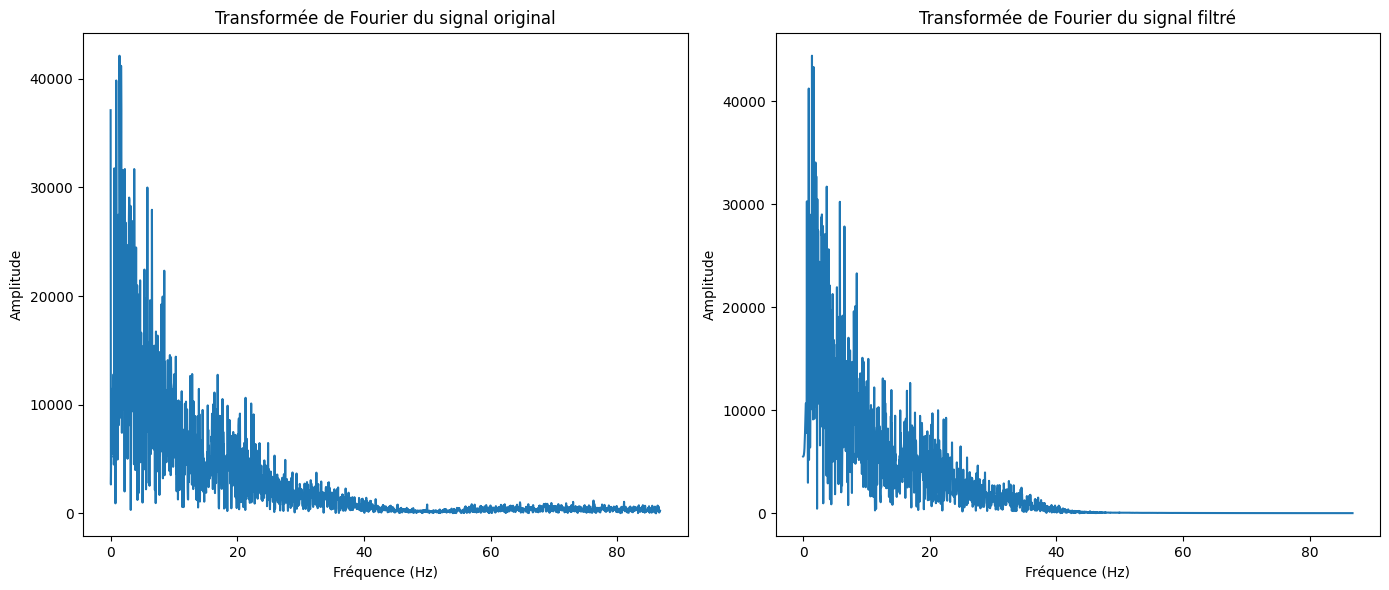

In [ ]:
#Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Diviser les données en ensembles d'entraînement, de validation et de test

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Préparer les DataLoader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 400
Ensemble de validation : 50
Ensemble de test : 50


## Visualize a Batch of Training Data

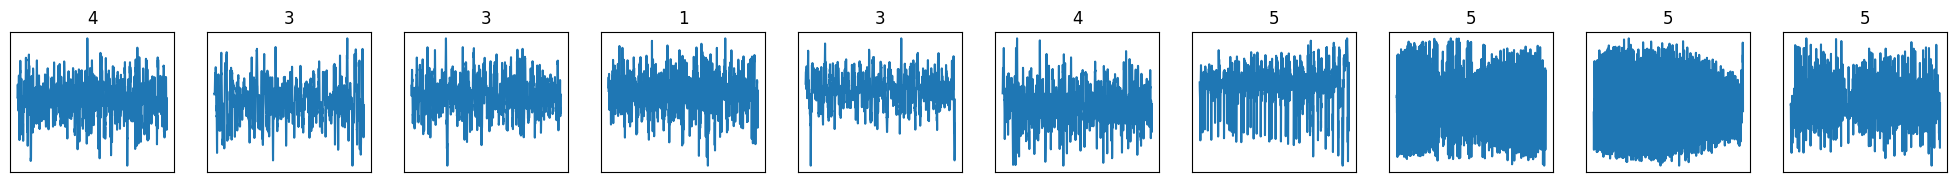

In [ ]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
signals, labels = next(dataiter)
signals = signals.numpy()

# Afficher les signaux dans le batch, avec les labels correspondants
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(batch_size, 20)):  # Afficher jusqu'à 20 signaux
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.plot(signals[idx])
    ax.set_title(str(int(labels[idx].item())))
plt.show()

---
## Define the Network Architecture

In [ ]:
# Parameters of the Network Architecture

learning_rate = 0.01
n_epochs = 5         # number of epochs to train the model
input_size = next(iter(train_loader))[0].shape[1]   # size of the input signals
num_classes = 2      # 2 classes (0 or 1)

### Define the Models

In [ ]:
# Model MSCN (Multi-Scale Convolutional Network)
class MSCN(nn.Module):
    def __init__(self):
        super().__init__()
        dropout = 0.5

        self.short_scale = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=50, stride=6, dilation=1, bias=False, padding=24), 
            nn.BatchNorm1d(64), 
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, 64, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=512, stride=42, dilation=1, bias=False, padding=256),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, 64, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.long_scale = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=1024, stride=84, dilation=1, bias=False, padding=512),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(64, 128, kernel_size=7, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, 64, kernel_size=7, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.dropout = nn.Dropout(dropout)
        self.fc_short = nn.Linear(60, 75)
        self.fc_medium = nn.Linear(12, 75)
        self.fc_long = nn.Linear(3, 75)

    def forward(self, x):
        x_short = self.short_scale(x)
        # print(x_short.shape[2]) # (128, 64, 60) for BioVid
        x_medium = self.medium_scale(x)
        # print(x_medium.shape[2]) # (128, 64, 12) for BioVid
        x_long = self.long_scale(x)
        # print(x_long.shape[2]) # (128, 64, 3) for BioVid

        x_short = self.fc_short(x_short)
        x_medium = self.fc_medium(x_medium)
        x_long = self.fc_long(x_long)

        x_concat = torch.cat((x_short, x_medium, x_long), dim=1)

        x_concat = self.dropout(x_concat)

        return x_concat

In [ ]:
# Model SEResNet (Residual network with squeeze-and-excitation blocks)

"""
This module contains the implementation of the SEResNet architecture.
"""

# First, we define the Squeeze-and-Excitation block.
class SENet(nn.Module):
    """
    Squeeze-and-Excitation block for channel-wise attention.
    """

    # First, the input is averaged using an adaptive average pooling layer to create a single value per channel.
    # Then, two fully connected layers are used to create the attention weights.
    # Finally, the input is multiplied by the attention weights to create the output.
    def __init__(self, channel, reduction=16): 
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential( # Create the fully connected layers
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x) # Multiply the input by the attention weights


# Second, we define the building block which prepares the input before sending it to the SE block and adds the 
# global input to the output of the SE block.
class SEBasicBlock(nn.Module):
    """
    Basic building block for squeeze-and-excitation networks with other layers.
    """
    expansion = 1

    # The block consists of two convolutional layers with batch normalization and ReLU activation functions.
    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.se = SENet(output_channels, reduction) # Send the output in the SE block
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # First convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Downsample if necessary
        if self.downsample is not None:
            residual = self.downsample(x)

        # Add residual connection and apply ReLU
        out += residual
        out = self.relu(out)

        return out


# Finaly, we create the ResNet architecture with 'blocks_size' number of SEBasicBlock instances put end-to-end.
class SEResNet(nn.Module):
    """
    Residual network with squeeze-and-excitation blocks

    Downsampling is performed by conv1 when stride != 1 or
    the input_channels size is not equal to the output size.
    """
    def __init__(self, output_channels, block_size):
        super(SEResNet, self).__init__()
        self.input_channels = 192 # Number of feature maps in the input
        self.block = SEBasicBlock 
        self.layer = self._make_layer(self.block, output_channels, block_size)

    # Create a layer with 'blocks' number of SEBasicBlock instances.
    def _make_layer(self, block, output_channels, blocks, stride = 1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride) # Downsample if necessary

        layers = [block(self.input_channels, output_channels, stride, downsample)] # Create the first block with downsample if necessary
        self.input_channels = output_channels * block.expansion # Update the number of feature maps depending on the block expansion
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks)) # Create the rest of the blocks

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)

In [ ]:
#la classe encoderwrapper englobe tout:
#elle appelle multiple couche de "transformerencoder", transformerencoder qui prend en entrée un multiheadattention et un mlp
#le sublayer output prend ensuite en entrée les multiheadattention et mlp et applique le modèle
#donc: encoderwrapper --> transformerencoder --> sublayeroutput --> convolution, multiheadattention, mlp et ce multiple fois

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from copy import deepcopy


# Utility function
def clones(module, N): 
    """
    Generate N identical layers

    Args:
        module (nn.Module): PyTorch module to be cloned
        N (int): Number of clones to create

    Returns:
        nn.ModuleList: List of N cloned PyTorch modules
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCN(nn.Module):
    """
    Temporal Convolutional Network with causal padding, residual connections, and batch normalization

    When kernel_size equals to zero, the padding is not causal
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        # If set batch_first=True, for nn.MultiheadAttention()
        # then the input and output tensors are provided as (batch, seq, feature(channels))
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True,
                                                         dropout=dropout)

    def forward(self, query, key, value):
        """
        We swap the seq and channel dimensions for the input tensors to
        meet the requirements of nn.MultiheadAttention()
        e.g. BioVid, (batch_size=128, seq_len=75, out_channels=30)
        :return: dimension (batch_size, out_channels, seq_len)
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        # Swap back to the original dimensions
        attn_output = attn_output.transpose(1, 2)
        return attn_output

class MLP(nn.Module):
    """
    Multi-Layer Perceptron
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        MLP forward pass
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    """
    Layer Normalization
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        print(self.a_2.shape, self.b_2.shape)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    """
    Residual connection followed by a layer norm.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x)) 


class TransformerEncoder(nn.Module):
    """
    Transformer Encoder

    Integration of MHA and MLP.
    Each of these sublayers have residual and layer norm, implemented by SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Encoder self-attention
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class EncoderWrapper(nn.Module):
    """
    Transformer Encoder Wrapper

    It is a stack of N layers of transformer encoder, default N=2.
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)

        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

